In [11]:

from functions import *

warnings.filterwarnings("ignore")




In [12]:
print(pd.__version__)
print(np.__version__)
print(sn.__version__)
print(sklearn.__version__)
print(plotly.__version__)
print(scipy.__version__)



1.2.4
1.20.1
0.11.1
0.24.1
5.3.1
1.8.1


In [13]:

x_axis = (np.array(pd.read_csv('data\\x_axis.csv').x))
data = pd.read_csv('data\\data.csv')


In [14]:


Smooth, Standartization, Baselin_corr, median_filter_parameter, first_diff, cut_range_from = True, True, False, False, False, 220

data = preprocess_data(data, Smooth, Standartization, Baselin_corr, median_filter_parameter, first_diff, cut_range_from)[0] 
    

val_set = data.query('concentr == 8 or concentr== 11')

data = data[~((data['concentr'] ==100) | (data['concentr'] ==8) | (data['concentr'] ==11))]        # убираю ненужные объекты


In [15]:
X_train, X_test,y_train,y_test=train_test_split(data[data.columns[:-3]],  data.concentr,
                                      test_size = 0.2, stratify = data.concentr, random_state = 42 )
min_error_test = 2

X_train, y_train = add_noise(X_train, y_train)
  
for alpha in tqdm(np.logspace(-6,6,30)):       
                model_lasso = SelectFromModel(Lasso(alpha = alpha).fit(X_train, y_train), prefit=True)
                X_train_1 = model_lasso.transform(X_train)
                if X_train_1.shape[1]==0:
                    continue
                X_test_1 = model_lasso.transform(X_test)
                clf = RidgeCV(alphas=np.logspace(-6,6,30), cv = 5).fit(X_train_1, y_train)
                clf.score(X_train_1, y_train)
                y_pred = clf.predict(X_test_1)
                error_test = mean_squared_error(y_test, y_pred, squared = False)
                if error_test<min_error_test:
                    min_error_test = error_test
                if clf.best_score_>0.9 and error_test <= min_error_test:

                    print('l1_alpha:',alpha, ',   l2_alpha: ', clf.alpha_)
                    print("train r^2: " ,clf.best_score_)
                    print ('test r^2 : ',r2_score(y_test, y_pred),',     test RMSE: ', error_test )

                    

  3%|██▊                                                                                | 1/30 [00:01<00:48,  1.67s/it]

l1_alpha: 1e-06 ,   l2_alpha:  0.09236708571873865
train r^2:  0.9651068948634697
test r^2 :  0.9428198267406234 ,     test RMSE:  1.8826611089167116


  7%|█████▌                                                                             | 2/30 [00:03<00:46,  1.66s/it]

l1_alpha: 2.592943797404667e-06 ,   l2_alpha:  0.09236708571873865
train r^2:  0.9651068948634697
test r^2 :  0.9428198267406234 ,     test RMSE:  1.8826611089167116


 10%|████████▎                                                                          | 3/30 [00:04<00:44,  1.64s/it]

l1_alpha: 6.723357536499335e-06 ,   l2_alpha:  0.09236708571873865
train r^2:  0.9651068948634697
test r^2 :  0.9428198267406234 ,     test RMSE:  1.8826611089167116


 13%|███████████                                                                        | 4/30 [00:06<00:42,  1.64s/it]

l1_alpha: 1.7433288221999873e-05 ,   l2_alpha:  0.09236708571873865
train r^2:  0.965243329428786
test r^2 :  0.9433043238107547 ,     test RMSE:  1.8746680918006977


 20%|████████████████▌                                                                  | 6/30 [00:09<00:38,  1.61s/it]

l1_alpha: 0.00011721022975334806 ,   l2_alpha:  0.09236708571873865
train r^2:  0.9678756430611648
test r^2 :  0.9443519250060876 ,     test RMSE:  1.8572676343677532


 30%|████████████████████████▉                                                          | 9/30 [00:12<00:23,  1.11s/it]

l1_alpha: 0.0020433597178569417 ,   l2_alpha:  0.09236708571873865
train r^2:  0.9764012120966491
test r^2 :  0.9482779556608516 ,     test RMSE:  1.7905533229714239


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.05it/s]


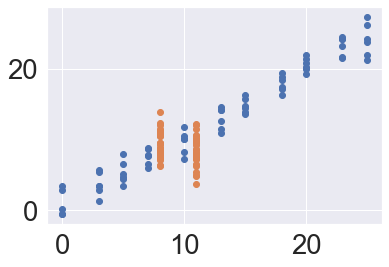

MSE 8.205934027340293 2.2642713805306074
R^2 : 0.9634716847933064


In [30]:


X_train, X_test,y_train,y_test=train_test_split(data[data.columns[:-3]],  data.concentr,
                                      test_size = 0.2, stratify = data.concentr, random_state = 38)

X_train, y_train = add_noise(X_train, y_train)


model_lasso = SelectFromModel(Lasso(alpha = 1e-06).fit(X_train, y_train), prefit=True)
reg = Ridge(alpha=0.09, random_state = 31).fit(model_lasso.transform(X_train), y_train)
y_pred = reg.predict(model_lasso.transform(X_test))
y_pred_val = reg.predict(model_lasso.transform((np.array(val_set)[:,:-3])))
plt.scatter(y_test, y_pred)
plt.scatter(val_set.concentr,y_pred_val )
plt.show()

print ('MSE', mean_squared_error(val_set.concentr, y_pred_val),mean_squared_error(y_test, y_pred))
print ('R^2 :', r2_score(y_test, y_pred))

In [32]:
las = Lasso(alpha = 1e-06).fit(X_train, y_train)
wei = np.zeros((X_train.shape[1]))
# Selecting not null regression weights
k = 0
for i in np.where(las.coef_!=0)[0]:
    wei[i] = reg.coef_[k]
    k+=1
for i in np.where(las.coef_==0)[0]:
    wei[i] = 0


fig = go.Figure()
fig.add_trace(go.Scatter(x = x_axis,
                                 y= savgol_filter(wei,9,3),
                       mode='lines'))

fig.update_xaxes(title_text = '$$ {Raman shift} \;\; (cm^{-1})  $$')
fig.update_yaxes(title_text='Loadings')
fig.update_layout( title='Loadings from model' ,  font=dict(
        size=20
    )
)
fig.show()

              precision    recall  f1-score   support

      0%GHSA       1.00      1.00      1.00         6
      3%GHSA       1.00      0.83      0.91         6
      5%GHSA       0.71      0.83      0.77         6
      7%GHSA       0.83      0.83      0.83         6
     10%GHSA       1.00      1.00      1.00         6
     13%GHSA       1.00      1.00      1.00         6
     15%GHSA       1.00      1.00      1.00         6
     18%GHSA       1.00      1.00      1.00         6
     20%GHSA       1.00      1.00      1.00         6
     23%GHSA       1.00      0.83      0.91         6
     25%GHSA       0.86      1.00      0.92         6

    accuracy                           0.94        66
   macro avg       0.95      0.94      0.94        66
weighted avg       0.95      0.94      0.94        66

None


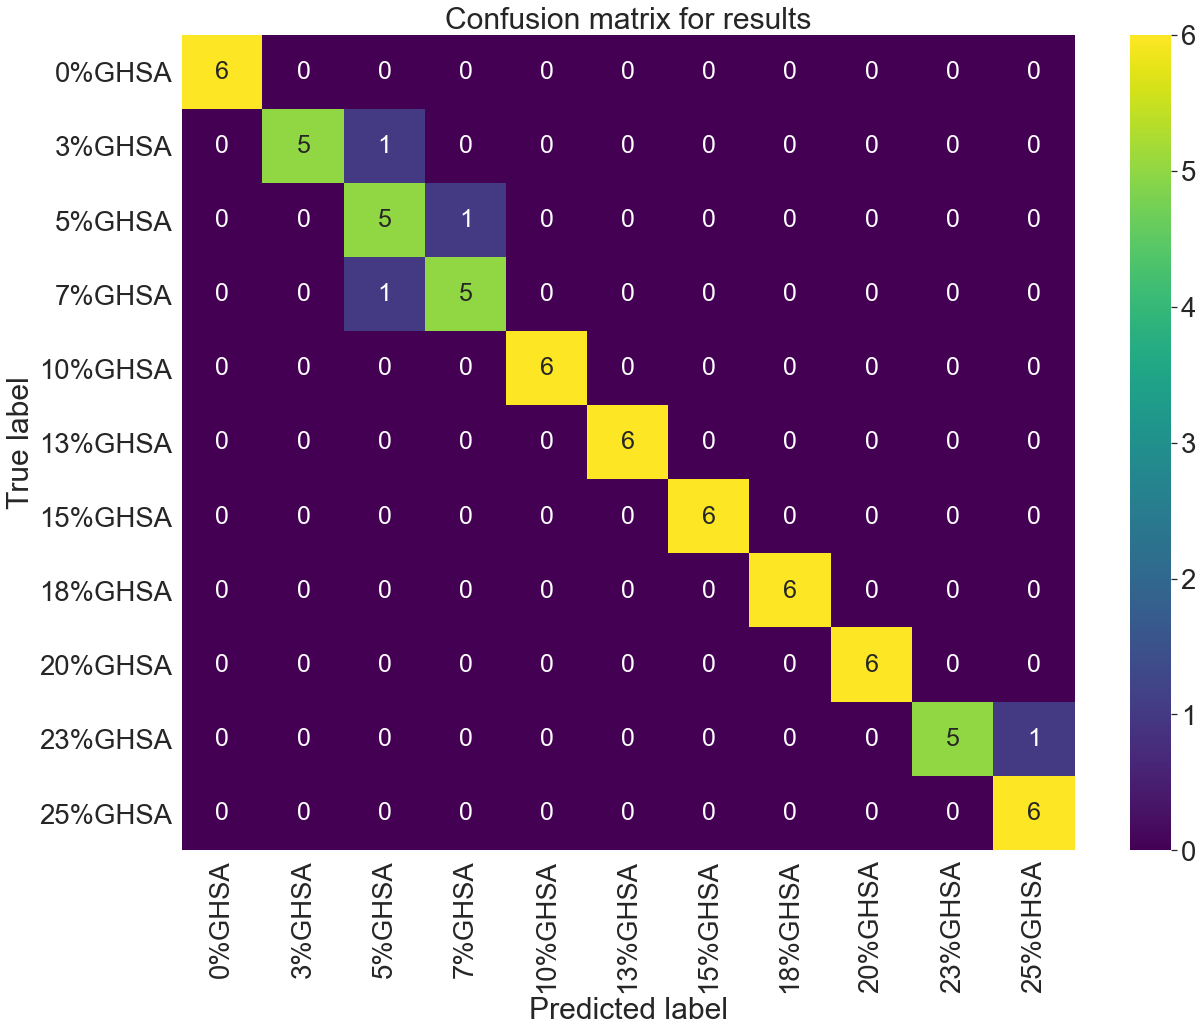

In [10]:
test = data.groupby('label', group_keys=False).apply(lambda x: x.sample(6,random_state = 67))
train = data.drop(data[data['conc'].isin(test['conc'])].index, inplace = False)

X_train, X_test, y_train, y_test = train[train.columns[:-3]], test[test.columns[:-3]],\
                                   train[train.columns[-3:]], test[test.columns[-3:]]
lda = LDA(n_components = 3)
lda.fit(X_train, list(y_train.label))
y_pred = lda.predict(X_test )

print (classification_rep((y_test.label), (y_pred)))

plot_confusion_matrix(y_test.label, y_pred)